## Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import random
import os
import math
import pickle

import pathlib
from pathlib import Path
from glob import glob

import pandas as pd
import cv2
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import CosineAnnealingLR, CyclicLR, CosineAnnealingWarmRestarts
from torchsummary import summary

import torchvision.models as models
from torchvision import transforms
from torchvision.transforms.transforms import Resize, CenterCrop, Lambda, RandomHorizontalFlip, RandomRotation, RandomVerticalFlip

from collections import OrderedDict

from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [2]:
!python -V

Python 3.7.13


In [6]:
import torch

print(torch.__version__)

1.11.0+cu113


## Hyperparameters Setting

In [ ]:
CFG = {
    'IMG_SIZE': 224,
    'EPOCHS': 100,
    'LEARNING_RATE': 0.005,
    'BATCH_SIZE': 128,
    'SEED': 41,
    'EPS' : 1e-12
}

## Fix RandomSeed

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Image Data Pre-processing Function 

In [ ]:
def get_train_data(data_dir):
    img_path_list = []
    label_list = []
    meta_list = pd.DataFrame()

    for case_name in os.listdir(data_dir):
        current_path = os.path.join(data_dir, case_name)
        if os.path.isdir(current_path):
            # get image path
            img_path_list.extend(sorted((glob(os.path.join(current_path, 'image', '*.jpg')))))
            img_path_list.extend(sorted((glob(os.path.join(current_path, 'image', '*.png')))))
            
            # get label
            label_df = pd.read_csv(current_path+'/label.csv')
            label_list.extend(label_df['leaf_weight'])
              
    return img_path_list, label_list

def get_test_data(data_dir):
    # get image path
    img_path_list = glob(os.path.join(data_dir, 'image', '*.jpg'))
    img_path_list.extend(glob(os.path.join(data_dir, 'image', '*.png')))
    img_path_list.sort(key=lambda x:int(x.split('/')[-1].split('.')[0]))
    return img_path_list

def transform_train_resize(img_path_list, img_size=(CFG['IMG_SIZE'], CFG['IMG_SIZE'])):
  """
  이미지의 여백에 해당하는 특정 지점의 배경색 평균 계산
  img_path_list : 이미지의 경로 저장 리스트
  return  사이즈 조정된 이미지 리스트, 추출된 특정지점의 배경 벡터값 (3, )
  """
  w, h = img_size[0], img_size[1]

  img_vector = []
  resized_img_ = []
  for idx, case in enumerate(img_path_list):
    if not(idx % 30):
      print(f'{idx} 진행 중')
    
    img = cv2.resize(cv2.imread(case), dsize=(w, h), interpolation=cv2.INTER_AREA)
    resized_img_.append(img)

    img_vector.append(img[w-1:, h-1:, :])
  img_vector = np.array(img_vector)
  img_vector = np.mean(img_vector, axis=0).reshape(-1)

  return resized_img_, img_vector


def transform_test_resize(img_path_list, img_size=(CFG['IMG_SIZE'], CFG['IMG_SIZE'])):
  w, h = img_size[0], img_size[1]
  resized_img_ = []
  for idx, case in enumerate(img_path_list):
    if not(idx % 30):
      print(f'{idx} 진행 중')
      
    img = cv2.resize(cv2.imread(case), dsize=(w, h), interpolation=cv2.INTER_AREA)
    resized_img_.append(img)

  return resized_img_


def transform_background(image_list, extracted_mean_vector=(243.09112333, 219.92615868, 223.38177533)):
  """
  특정 지점의 배경색을 모두 평균과 같도록 이미지에 numpy 연산을 시행하여 명암의 분산이 줄어들도록 이미지 전처리
  resized_img_: 사이즈 조정된 이미지
  extracted_mean_vector: 추출된 특정지점의 배경 벡터값 (3, )
  return 모든 이미지가 추출된 특정지점의 평균과 동일하도록 정규화된 이미지
  """
  w, h = image_list[0].shape[0], image_list[0].shape[1]
  v1, v2, v3 =  extracted_mean_vector
  new_image_ = []
  for image in image_list:
    c1, c2, c3 = image[w-1:, h-1:, :].reshape(-1)
    
    condition_1 = np.where((image[:, :, 0] - (c1 - v1)) > 0 , (image[:, :, 0] - (c1 - v1)), 0)
    condition_2 = np.where((image[:, :, 1] - (c2 - v2)) > 0 , (image[:, :, 1] - (c2 - v2)), 0)
    condition_3 = np.where((image[:, :, 2] - (c3 - v3)) > 0 , (image[:, :, 2] - (c3 - v3)), 0)

    new_c1 = np.where(condition_1 < 255 , condition_1, 255)[..., np.newaxis] / 255.
    new_c2 = np.where(condition_2 < 255 , condition_2, 255)[..., np.newaxis] / 255.
    new_c3 = np.where(condition_3 < 255 , condition_3, 255)[..., np.newaxis] / 255.

    new_image = np.concatenate((new_c1, new_c2, new_c3), axis=2)
    new_image_.append(new_image)

  return new_image_


def transform_mask(image_list, threshold=0.64, alpha=0.7):
  """
  마스킹 처리
  image: 정규화된 이미지
  threshold: 마스킹 임계점
  alpha: 노이즈 처리(임계점으로 해결이 안될 경우 조정하는 변수)
  return 마스킹된 이미지 리스트
  """
  mask_ = []
  for image in image_list:
    ret, mask = cv2.threshold(image, threshold, 1, cv2.THRESH_BINARY) 
    mask = np.abs(mask - 1)
    mask = np.where(mask > alpha, mask, 0)
    a, b = np.where(((mask[:, :, 0] == 0) & (mask[:, :, 1] == 1) & (mask[:, :, 2] == 1)) |\
                    ((mask[:, :, 0] == 0) & (mask[:, :, 1] == 0) & (mask[:, :, 2] == 1)) |\
                    ((mask[:, :, 0] == 0) & (mask[:, :, 1] == 1) & (mask[:, :, 2] == 0)))

    mask[a, b, :] = 0
    
    a, b = np.where(((mask[:, :, 0] == 1) & (mask[:, :, 1] == 1) & (mask[:, :, 2] == 0)) |\
                    ((mask[:, :, 0] == 1) & (mask[:, :, 1] == 0) & (mask[:, :, 2] == 0)) |\
                    ((mask[:, :, 0] == 1) & (mask[:, :, 1] == 0) & (mask[:, :, 2] == 1)))
    mask[a, b, :] = 1

    mask_.append(mask)
  
  return mask_

def plot_img(img_list, first_idx_and_last_idx=(0, 9)):
  plt.figure(figsize=(10, 10))
  for idx, img in enumerate(img_list[first_idx_and_last_idx[0]:first_idx_and_last_idx[1]]):
    plt.subplot(3, 3, idx+1)
    plt.imshow(img)
  plt.show()

def plot_mask_img(mask_, all_img_path_, label_):
  plt.figure(figsize=(100, 100))
  for idx, (mask, name, label) in enumerate(zip(mask_, all_img_path_, label_)):
    plt.subplot(30, 50, idx+1)
    plt.imshow(mask)
    plt.xticks()
    plt.yticks()
    plt.title(name[-9:-4]+'_'+str(f'{label:.1f}'))
  plt.show()

def plot_mask_test_img(mask_, all_img_path_):
  plt.figure(figsize=(100, 100))
  for idx, (mask, name) in enumerate(zip(mask_, all_img_path_)):
    plt.subplot(30, 50, idx+1)
    plt.imshow(mask)
    plt.xticks()
    plt.yticks()
    plt.title(name[-9:-4])
  plt.show()

## Meta Data Pre-processing Function 

In [ ]:
def data_processing(df, train_set=True):
  
  path = './pickle'
  # 타입 변환

  df = df.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
  df['시간'] = pd.to_datetime(df['시간'], format='%Y-%m-%d %H:%M:%S', errors='raise')
 
  df['m_d'] = df['시간'].dt.strftime("%m-%d")
  df['group'] = df['시간'].dt.strftime("%y-%m-%d-%H")


  # 광추정량 (공식)
  
  lay_white_nan_idx = np.where(df['백색광추정광량'].isnull())[0]
  lay_blue_nan_idx = np.where(df['청색광추정광량'].isnull())[0]
  lay_red_nan_idx = np.where(df['적색광추정광량'].isnull())[0]

  dlw, dlb, dlr = len(lay_white_nan_idx), len(lay_blue_nan_idx), len(lay_red_nan_idx)
  blw = blb = blr = -1

  df.loc[lay_white_nan_idx, '백색광추정광량'] = df.loc[lay_white_nan_idx, '화이트 LED동작강도'] * 0.01 * 309.41
  df.loc[lay_blue_nan_idx, '청색광추정광량'] = df.loc[lay_blue_nan_idx, '블루 LED동작강도'] * 0.01 * 156.65
  df.loc[lay_red_nan_idx, '적색광추정광량'] = df.loc[lay_red_nan_idx, '레드 LED동작강도'] * 0.01 * 165.48

  LED_white_nan_idx = np.where(df['화이트 LED동작강도'].isnull())[0]
  LED_blue_nan_idx = np.where(df['블루 LED동작강도'].isnull())[0]
  LED_red_nan_idx = np.where(df['레드 LED동작강도'].isnull())[0]

  dLw, dLb, dLr = len(LED_white_nan_idx), len(LED_blue_nan_idx), len(LED_red_nan_idx)
  bLw = bLb = bLr = -1

  df.loc[LED_white_nan_idx, '화이트 LED동작강도'] = df.loc[LED_white_nan_idx, '백색광추정광량'] * 100 / 309.41
  df.loc[LED_blue_nan_idx, '블루 LED동작강도'] = df.loc[LED_blue_nan_idx, '청색광추정광량'] * 100 / 156.65
  df.loc[LED_red_nan_idx, '레드 LED동작강도'] = df.loc[LED_red_nan_idx, '적색광추정광량'] * 100 / 165.48

  total_estimation = np.where(~df['백색광추정광량'].isnull() & ~df['청색광추정광량'].isnull() & ~df['적색광추정광량'].isnull() & df['총추정광량'].isnull())[0]
  df.loc[total_estimation, '총추정광량'] = df.loc[total_estimation, '백색광추정광량'] + df.loc[total_estimation, '청색광추정광량'] + df.loc[total_estimation, '적색광추정광량']

  dte = len(total_estimation)
  bte = -1

  white_error_ohter_nan_idx = np.where(df['백색광추정광량'].isnull() & ~df['청색광추정광량'].isnull() & ~df['적색광추정광량'].isnull())[0]
  blue_error_other_nan_idx = np.where(df['청색광추정광량'].isnull() & ~df['백색광추정광량'].isnull() & ~df['적색광추정광량'].isnull())[0]
  red_error_other_nan_idx = np.where(df['적색광추정광량'].isnull() & ~df['백색광추정광량'].isnull() & ~df['청색광추정광량'].isnull())[0]

  dwe, dbe, dre = len(white_error_ohter_nan_idx), len(blue_error_other_nan_idx), len(red_error_other_nan_idx)
  bwe = bbe = bre = -1
  cnt = 0

  while True:
    cnt += 1
    print(cnt)

    if cnt > 20:
      break # Error 대비

    df.loc[white_error_ohter_nan_idx, '백색광추정광량'] = df.loc[white_error_ohter_nan_idx, '총추정광량'] - df.loc[white_error_ohter_nan_idx, '청색광추정광량'] - df.loc[white_error_ohter_nan_idx, '적색광추정광량']
    df.loc[blue_error_other_nan_idx, '청색광추정광량'] = df.loc[blue_error_other_nan_idx, '총추정광량'] - df.loc[blue_error_other_nan_idx, '백색광추정광량'] - df.loc[blue_error_other_nan_idx, '적색광추정광량']
    df.loc[red_error_other_nan_idx, '적색광추정광량'] = df.loc[red_error_other_nan_idx, '총추정광량'] - df.loc[red_error_other_nan_idx, '백색광추정광량'] - df.loc[red_error_other_nan_idx, '청색광추정광량']

    bwe, bbe, bre = len(white_error_ohter_nan_idx), len(blue_error_other_nan_idx), len(red_error_other_nan_idx)
    
    white_error_ohter_nan_idx = np.where(df['백색광추정광량'].isnull() & ~df['청색광추정광량'].isnull() & ~df['적색광추정광량'].isnull())[0]
    blue_error_other_nan_idx = np.where(df['청색광추정광량'].isnull() & ~df['백색광추정광량'].isnull() & ~df['적색광추정광량'].isnull())[0]
    red_error_other_nan_idx = np.where(df['적색광추정광량'].isnull() & ~df['백색광추정광량'].isnull() & ~df['청색광추정광량'].isnull())[0]

    dwe, dbe, dre = len(white_error_ohter_nan_idx), len(blue_error_other_nan_idx), len(red_error_other_nan_idx)

    # repeat
    blw, blb, blr = len(lay_white_nan_idx), len(lay_blue_nan_idx), len(lay_red_nan_idx)
    bLw, bLb, bLr = len(LED_white_nan_idx), len(LED_blue_nan_idx), len(LED_red_nan_idx)
    bte = len(total_estimation)

    lay_white_nan_idx = np.where(df['백색광추정광량'].isnull())[0]
    lay_blue_nan_idx = np.where(df['청색광추정광량'].isnull())[0]
    lay_red_nan_idx = np.where(df['적색광추정광량'].isnull())[0]

    dlw, dlb, dlr = len(lay_white_nan_idx), len(lay_blue_nan_idx), len(lay_red_nan_idx)

    df.loc[lay_white_nan_idx, '백색광추정광량'] = df.loc[lay_white_nan_idx, '화이트 LED동작강도'] * 0.01 * 309.41
    df.loc[lay_blue_nan_idx, '청색광추정광량'] = df.loc[lay_blue_nan_idx, '블루 LED동작강도'] * 0.01 * 156.65
    df.loc[lay_red_nan_idx, '적색광추정광량'] = df.loc[lay_red_nan_idx, '레드 LED동작강도'] * 0.01 * 165.48

    LED_white_nan_idx = np.where(df['화이트 LED동작강도'].isnull())[0]
    LED_blue_nan_idx = np.where(df['블루 LED동작강도'].isnull())[0]
    LED_red_nan_idx = np.where(df['레드 LED동작강도'].isnull())[0]

    dLw, dLb, dLr = len(LED_white_nan_idx), len(LED_blue_nan_idx), len(LED_red_nan_idx)

    df.loc[LED_white_nan_idx, '화이트 LED동작강도'] = df.loc[LED_white_nan_idx, '백색광추정광량'] * 100 / 309.41
    df.loc[LED_blue_nan_idx, '블루 LED동작강도'] = df.loc[LED_blue_nan_idx, '청색광추정광량'] * 100 / 156.65
    df.loc[LED_red_nan_idx, '레드 LED동작강도'] = df.loc[LED_red_nan_idx, '적색광추정광량'] * 100 / 165.48

    total_estimation = np.where(~df['백색광추정광량'].isnull() & ~df['청색광추정광량'].isnull() & ~df['적색광추정광량'].isnull() & df['총추정광량'].isnull())[0]
    df.loc[total_estimation, '총추정광량'] = df.loc[total_estimation, '백색광추정광량'] + df.loc[total_estimation, '청색광추정광량'] + df.loc[total_estimation, '적색광추정광량']

    dte = len(total_estimation)

    if (bwe == dwe) and (bbe == dbe) and (bre == dre) and (blw == dlw) and (blb == dlb) and (blr == dlr) and \
      (bLw == dLw) and (bLb == dLb) and (bLr == dLr) and (bte == dte):
      break

  # Cooling Error

  cooling_error_idx = np.where(df['냉방부하'].isnull())[0]

  cooling_error_zero_meaning_columns = ['최근분무량', '화이트 LED동작강도', '레드 LED동작강도', '블루 LED동작강도', \
                                      '냉방온도', '냉방부하', '난방온도', '난방부하', '총추정광량', '백색광추정광량', \
                                      '적색광추정광량', '청색광추정광량']

  df.loc[cooling_error_idx, cooling_error_zero_meaning_columns] = 0


  g_inf = df['내부온도관측치'].groupby(df['m_d']).mean()
  m_d_list = g_inf.index

  g_inf = pd.Series(g_inf.to_numpy()).interpolate('polynomial', order=5)
  g_of = pd.Series(df['외부온도관측치'].groupby(df['m_d']).mean().to_numpy()).interpolate('polynomial', order=5)

  g_ih = pd.Series(df['내부습도관측치'].groupby(df['m_d']).mean().to_numpy()).interpolate('polynomial', order=3)
  g_oh = pd.Series(df['외부습도관측치'].groupby(df['m_d']).mean().to_numpy()).interpolate('polynomial', order=1)

  g_co2 = pd.Series(df['CO2관측치'].groupby(df['m_d']).mean().to_numpy()).interpolate('polynomial', order=1)
  g_ec = df['EC관측치'].groupby(df['m_d']).mean().to_numpy()

  for idx, m_d in enumerate(m_d_list):
    df.loc[np.where((df['m_d']==m_d) & (df['내부온도관측치'].isnull()))[0], '내부온도관측치'] = g_inf[idx]
    df.loc[np.where((df['m_d']==m_d) & (df['외부온도관측치'].isnull()))[0], '외부온도관측치'] = g_of[idx]
    df.loc[np.where((df['m_d']==m_d) & (df['내부습도관측치'].isnull()))[0], '내부습도관측치'] = g_ih[idx]
    df.loc[np.where((df['m_d']==m_d) & (df['외부습도관측치'].isnull()))[0], '외부습도관측치'] = g_oh[idx]
    df.loc[np.where((df['m_d']==m_d) & (df['CO2관측치'].isnull()))[0], 'CO2관측치'] = g_co2[idx]
    df.loc[np.where((df['m_d']==m_d) & (df['EC관측치'].isnull()))[0], 'EC관측치'] = g_ec[idx]



  for i in ['내부온도관측치', '외부온도관측치', '내부습도관측치', '외부습도관측치', 'CO2관측치', '최근분무량', '화이트 LED동작강도', '레드 LED동작강도', '블루 LED동작강도', \
            '냉방온도', '냉방부하', '난방온도', '난방부하', '총추정광량', '백색광추정광량', '적색광추정광량', '청색광추정광량']:

    df[i] = df[i].fillna(method='ffill')


  # 냉방난방
  df['냉방-난방'] = df['냉방온도'] - df['난방온도']
  
  # 내부 - 외부 온도가 크다면, 외부에 비해 따뜻하다는 것 => 청경채는 고랭지 채소이므로 더우면 안된다. 따라서, 이상치로 판단
  df['온도차']= df['내부온도관측치'] - df['외부온도관측치']

  # 습도차
  df['습도차'] = df['내부습도관측치'] - df['외부습도관측치']

  # 냉온방 부하율
  df['냉방부하율'] = (df['냉방부하'] / (df['냉방온도'] + 1e-12))
  df['난방부하율'] = (df['난방부하'] / (df['난방부하'] + 1e-12))
  df['총부하량'] = df['냉방부하'] + df['난방부하']

  # 맨 마지막 EC 예측
  filename = path + '/xgb_model.model'

  # 모델 불러와서 EC 예측
  xgb_model = pickle.load(open(filename, 'rb'))

  tdf = df[['내부습도관측치','외부습도관측치','CO2관측치', '최근분무량', '총추정광량', '내부온도관측치', '외부온도관측치', 'EC관측치']]

  test_idx = np.where(tdf['EC관측치'].isnull())[0]

  X_test = df.iloc[test_idx]
  y_test = X_test.pop('EC관측치')

  X_test = X_test[['내부습도관측치','외부습도관측치','CO2관측치', '최근분무량', '총추정광량', '내부온도관측치', '외부온도관측치']]
  prediction = xgb_model.predict(X_test)
  df.loc[test_idx, 'EC관측치'] = prediction

  # 0시, 12시만 활용
  df['hour'] = df['시간'].dt.hour
  df['minute'] = df['시간'].dt.minute

  df_0 = df.iloc[np.where(((df['hour'] == 0) & (df['minute'] == 0)))[0]]
  df_12 = df.iloc[np.where(((df['hour'] == 12) & (df['minute'] == 0)))[0]]

  df_0 = df_0.drop(['시간', 'm_d', 'group', 'hour', 'minute'], axis=1)
  df_12 = df_12.drop(['시간', 'm_d', 'group', 'hour', 'minute'], axis=1)

  new_df_0_columns_ = []
  new_df_12_columns_ = []


  # Trainset은 케이스 및 이름이 존재하므로, 데이터가 섞이지 않도록 Case, Name으로 구분, Testset에는 Case가 없으므로 Name으로만 구분  
  if train_set:

    for i, j in zip(df_0.columns, df_12.columns):
      if i in ['Case', 'Name']:
        new_df_0_columns_.append(i)
      else:
        new_df_0_columns_.append('0시 ' + i)
      new_df_12_columns_.append('12시 ' + j)

    df_0.columns = new_df_0_columns_
    df_12.columns = new_df_12_columns_

    df_0 = df_0.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
    df_12 = df_12.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')

    df_t = pd.concat([df_0, df_12], axis=1)
    if np.sum(df_t['Case'] == df_t['12시 Case']) == np.sum(df_t['Name'] == df_t['12시 Name']) == len(df_t):
      df_t = df_t.drop(['12시 Case', '12시 Name'], axis=1)
    else:
      print('error')

  else:
    
    for i, j in zip(df_0.columns, df_12.columns):
      if i == 'Name':
        new_df_0_columns_.append(i)
      else:
        new_df_0_columns_.append('0시 ' + i)
      new_df_12_columns_.append('12시 ' + j)

    df_0.columns = new_df_0_columns_
    df_12.columns = new_df_12_columns_

    df_0 = df_0.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
    df_12 = df_12.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')

    df_t = pd.concat([df_0, df_12], axis=1)
    if np.sum(df_t['Name'] == df_t['12시 Name']) == len(df_t):
      df_t = df_t.drop(['12시 Name'], axis=1)
    else:
      print('error')

  return df, df_t

## Data Pre-processing

In [ ]:
with open("./pickle/meta_df_t.pickle","rb") as fr:
  meta_df_t = pickle.load(fr)

with open("./pickle/meta_test_df_te","rb") as fr:
  meta_df_te = pickle.load(fr)

# os.chdir(path)

In [ ]:
meta_df_t = meta_df_t[['0시 EC관측치', '12시 EC관측치', '0시 온도차','0시 습도차', '12시 온도차', '12시 습도차', 'Case', 'Name']]
meta_df_te = meta_df_te[['0시 EC관측치', '12시 EC관측치', '0시 온도차','0시 습도차', '12시 온도차', '12시 습도차', 'Name']]

In [ ]:
# 기본 경로
train_path = './train'
test_path = './test'

# all_img_path, all_label = get_train_data(train_path)
# test_img_path = get_test_data(test_path)

with open('./pickle/all_img_path.pickle', 'rb') as f:
	all_img_path = pickle.load(f)
  
with open('./pickle/all_label.pickle', 'rb') as f:
	all_label = pickle.load(f)
 
with open('./pickle/test_img_path.pickle', 'rb') as f:
	test_img_path = pickle.load(f)

train_len = int(len(all_img_path)*0.8)

train_img_path = all_img_path[:train_len]
train_meta_ = meta_df_t[:train_len]
train_label = all_label[:train_len]

vali_img_path = all_img_path[train_len:]
vali_meta_ = meta_df_t[train_len:]
vali_label = all_label[train_len:]

with open('./pickle/train_img_mask_0_64.pickle', 'rb') as f:
	train_img_mask_ = pickle.load(f)
  
with open('./pickle/test_img_mask_0_64.pickle', 'rb') as f:
	test_img_mask_ = pickle.load(f)
 
train_np_sum = []
test_np_sum = []

for s in train_img_mask_:
  train_np_sum.append(np.sum(s))

for s in test_img_mask_:
  test_np_sum.append(np.sum(s))

## Data Sequence Checking

In [ ]:
# 데이터 순서 체크
meta_df_t['CaseName'] = meta_df_t['Case'] + '_' + meta_df_t['Name']
test_seq = True
for i, j in zip(range(len(all_img_path)), meta_df_t['CaseName']):
  if all_img_path[i][-9:-4] != j:
    print(j)
    test_seq = False
print(f'Sequence Checking Train: {test_seq}')


test_seq = True
for i, j in zip(range(len(test_img_path)), meta_df_te['Name']):
  if test_img_path[i][-7:-4] != j:
    print(j)
    test_seq = False
print(f'Sequence Checking Test: {test_seq}')

meta_df_t = meta_df_t.drop(['Case', 'Name', 'CaseName'], axis=1)

meta_df_te = meta_df_te.drop(['Name'], axis=1)

# 이상치 제거
idx = -1
for i, p in enumerate(all_img_path):
  if p[-9:-4] == '45_17':
    idx = i

meta_df_t = meta_df_t.drop(idx, axis=0)
train_np_sum.pop(idx)

meta_df_t['행렬 합'] =  train_np_sum
meta_df_te['행렬 합'] =  test_np_sum

meta_df_t = meta_df_t.to_numpy()
meta_df_te = meta_df_te.to_numpy()
print(f'image_path_remove: {all_img_path.pop(idx)}')
print(f'image_mask_remove:{train_img_mask_.pop(idx)}')
print(f'label_remove:{all_label.pop(idx)}')
print(f'meta_df_t.shape: {meta_df_t.shape}')
print(f'meta_df_te.shape: {meta_df_te.shape}')

scaler = StandardScaler()
meta_df_t = scaler.fit_transform(meta_df_t) 
meta_df_te = scaler.transform(meta_df_te)

Sequence Checking Train: True
Sequence Checking Test: True
image_path_remove: /content/drive/MyDrive/Colab Notebooks/kist/train/CASE45/image/CASE45_17.png
image_mask_remove:[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
label_remove:98.233
meta_df_t.shape: (1591, 7)
meta_df_te.shape: (460, 7)


## Define Model Architecture

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, img_list, meta_list, label_list, train_mode=True, transforms=None):
        self.transforms = transforms
        self.train_mode = train_mode
        self.img_path_list = img_list
        self.meta_list = meta_list
        self.label_list = label_list

    def __getitem__(self, index):
        image = self.img_path_list[index]
        meta = self.meta_list[index]

        # Get image data
        if self.transforms is not None:
            image = self.transforms(image)

        if self.train_mode:
            meta = self.meta_list[index]
            label = self.label_list[index]
            return image, meta, label

        else:
            return image, meta
    
    def __len__(self):
        return len(self.img_path_list)

In [ ]:
# Resnet 256, EfficientNet 224
train_transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.RandomHorizontalFlip(0.4),
                    transforms.RandomVerticalFlip(0.4),
                    transforms.RandomRotation(0.3),
                    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                    ])

test_transform = transforms.Compose([
                    transforms.ToTensor(),
                    #transforms.CenterCrop(224),
                    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                    ])

In [ ]:
# Train : Validation = 0.8 : 0.2 Split
train_len = int(len(all_img_path)*0.80)

train_img_ = train_img_mask_[:train_len]
train_meta_ = meta_df_t[:train_len, -1][..., np.newaxis]
train_label = all_label[:train_len]

vali_img_ = train_img_mask_[train_len:]
vali_meta_ = meta_df_t[train_len:, -1][..., np.newaxis]
vali_label = all_label[train_len:]

test_img_ = test_img_mask_[:]
test_meta_ = meta_df_te[:, -1][..., np.newaxis]

In [ ]:
# Get Dataloader
train_dataset = CustomDataset(train_img_, train_meta_, train_label, train_mode=True, transforms=train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

vali_dataset = CustomDataset(vali_img_, vali_meta_, vali_label, train_mode=True, transforms=test_transform)
vali_loader = DataLoader(vali_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

## Visualize Image

In [ ]:
plot_mask_img(train_img_[:500], all_img_path, train_label)

Output hidden; open in https://colab.research.google.com to view.

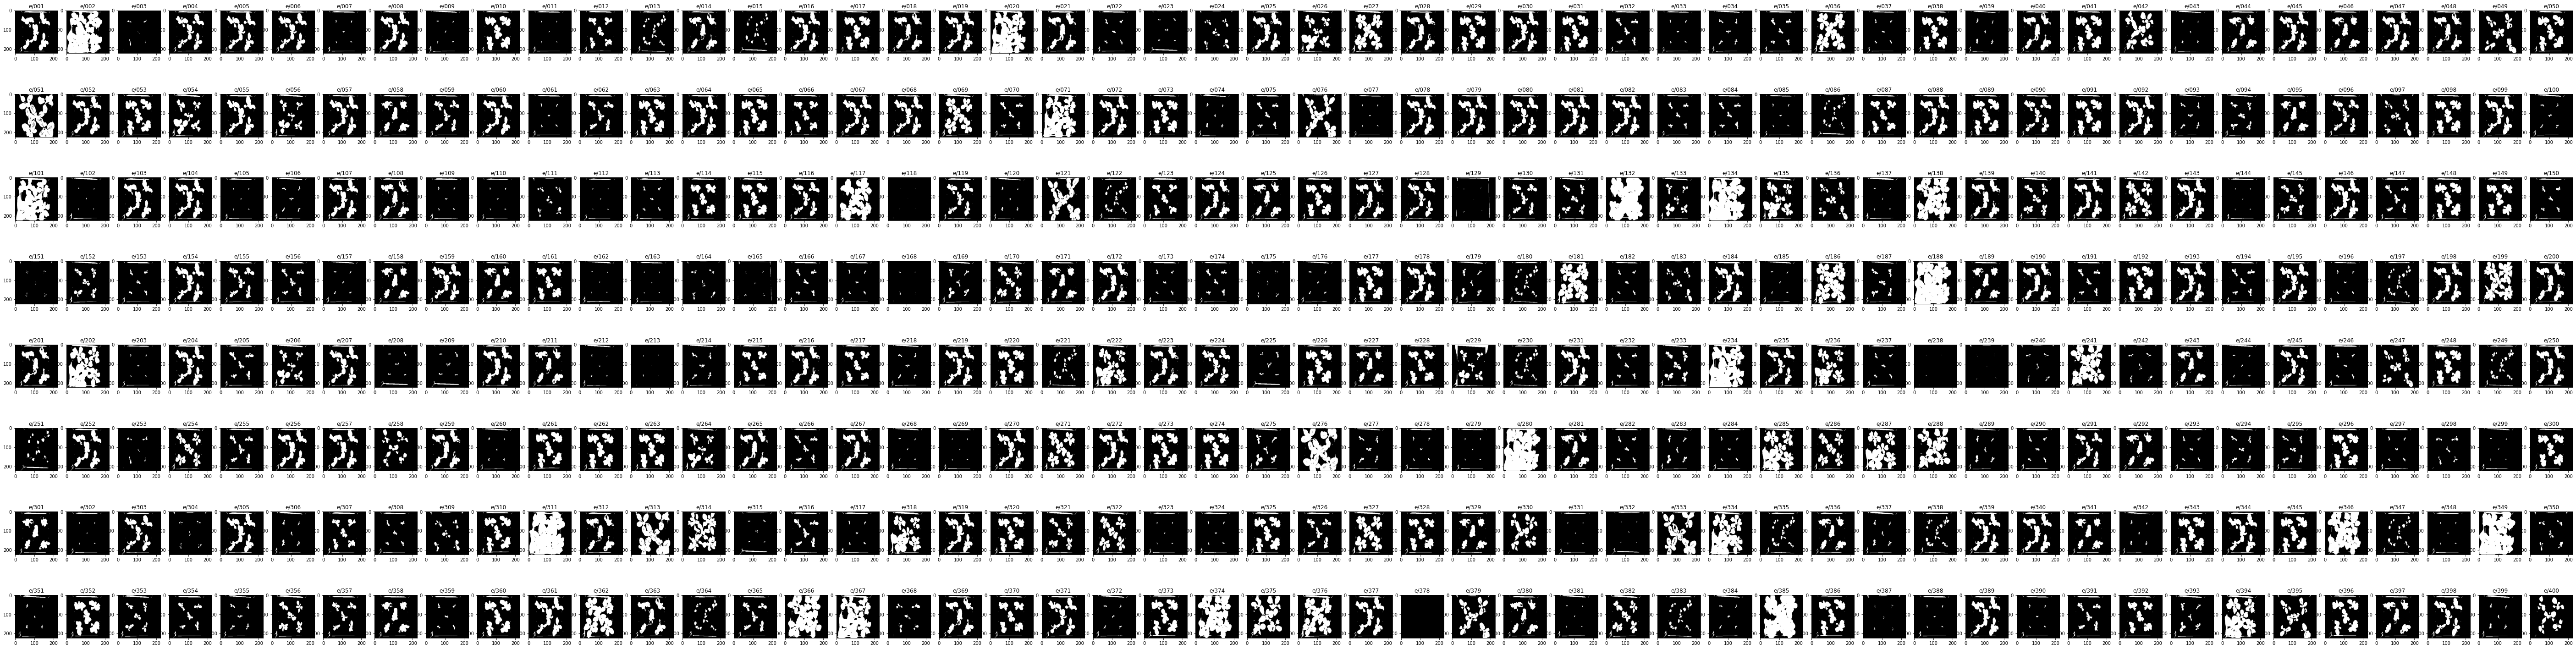

In [ ]:
plot_mask_test_img(test_img_[:400], test_img_path)

## Pretrained Model

In [ ]:
model_effnet0 = models.efficientnet_b0(pretrained=True)

for p in model_effnet0.parameters():
  p.requires_grad = False

classifier_name, old_classifier = model_effnet0._modules.popitem()
classifier_input_size = old_classifier[1].in_features


classifier = nn.Sequential(OrderedDict([
                           ('0', nn.Dropout(p=0.2)),
                           ('1', nn.PReLU()),
                           ('2', nn.Linear(in_features=classifier_input_size, out_features=128, bias=True)),
                           ('3', nn.BatchNorm1d(128)),
                           ('4', nn.Linear(in_features=128, out_features=1, bias=True)),
                           ]))

model_effnet0.add_module(classifier_name, classifier)
model_effnet0 = model_effnet0.to(device)

print(f'Linear:\t{model_effnet0.classifier}')

Linear:	Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): PReLU(num_parameters=1)
  (2): Linear(in_features=1280, out_features=128, bias=True)
  (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Linear(in_features=128, out_features=1, bias=True)
)


## CNN Multi Regressor

In [ ]:
class CNNRegressor(torch.nn.Module):
    def __init__(self):
        super(CNNRegressor, self).__init__()

        self.cnn = models.efficientnet_b0(pretrained=True)

        for p in self.cnn.parameters():
          p.requires_grad = False

        classifier_name, old_classifier = self.cnn._modules.popitem()
        classifier_input_size = old_classifier[1].in_features

        classifier = nn.Sequential(OrderedDict([
                                   ('0', nn.Dropout(p=0.2)),
                                   ('1', nn.PReLU()),
                                   ('2', nn.Linear(in_features=classifier_input_size, out_features=128, bias=True)),
                                   ('3', nn.BatchNorm1d(128)),
                                   ('4', nn.Linear(in_features=128, out_features=1, bias=True)),
                                   ]))
        
        self.cnn.add_module(classifier_name, classifier)

        self.cnn = self.cnn.to(device)
        self.fc1 = nn.Linear(1 + 1, 16)
        self.fc1 = self.fc1.to(device)

        self.fc2 = nn.BatchNorm1d(16)
        self.fc2 = self.fc2.to(device)

        self.fc3 = nn.Linear(16, 1)
        self.fc3 = self.fc3.to(device)

    def forward(self, image, data):
      x1 = self.cnn(image)
      x2 = data.to(device)

      x = torch.cat((x1, x2), dim=1)
      x = self.fc1(x)
      x = self.fc2(x)
      x = self.fc3(x)

      return x

## Train

In [ ]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=50, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
def validation(model, vali_loader, criterion, device):
    model.eval() # Evaluation
    vali_loss = []
    vali_true = []
    with torch.no_grad():
        for img, meta, label in tqdm(iter(vali_loader)):
            img, meta, label = img.float().to(device), meta.float().to(device), label.float().to(device)

            logit = model(img, meta)
            #logit = model(img)
            
            # for idx, i in enumerate(logit):
            #   if i < 0:
            #     logit[idx] = 0

            loss = criterion(logit.squeeze(1), label)
            #print(loss)
            
            vali_loss.append(loss.item())
            vali_true.extend(label.tolist())

    vali_true_tensor = torch.abs(torch.tensor(vali_true))
    vali_nmae_loss = np.mean(vali_loss) / torch.mean(vali_true_tensor)
    return vali_nmae_loss

In [ ]:
def train(model, optimizer, train_loader, vali_loader, scheduler, device, name):
    model.to(device)

    # Loss Function
    criterion = nn.L1Loss().to(device)
    best_nmae = 0.3
    train_nmae_list = []
    vali_nmae_list = []
    vali_best_nmae_list = []

    torch_save_dict = {}

    early_stopping = EarlyStopping(patience=50, verbose=True)

    for epoch in range(1,CFG["EPOCHS"]+1):
    #for epoch in range(1,2):  
        model.train()
        train_loss = []
        train_true = []
        for img, meta, label in tqdm(iter(train_loader)):
            img, meta, label = img.float().to(device), meta.float().to(device), label.float().to(device)

            
            optimizer.zero_grad()

            # Data -> Model -> Output
            logit = model(img, meta)
            #logit = model(img)
            
            # for idx, i in enumerate(logit):
            #   if i < 0:
            #     logit[idx] = 0

            # Calc loss
            loss = criterion(logit.squeeze(1), label)
            #print(loss)

            # backpropagation
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            train_true.extend(label.tolist())

        if scheduler is not None:
            scheduler.step()

        train_true_tensor = torch.abs(torch.tensor(train_true))
        train_nmae = np.mean(train_loss) / torch.mean(train_true_tensor)
            
        # Evaluation Validation set
        vali_nmae = validation(model, vali_loader, criterion, device)
        
        print(f'Epoch [{epoch}] Train NMAE : [{train_nmae:.5f}] Validation MAE : [{vali_nmae:.5f}]\n')
        
        train_nmae_list.append(train_nmae)
        vali_nmae_list.append(vali_nmae)

        # Model Saved
        if best_nmae > vali_nmae:
          if train_nmae < 0.4:
            best_nmae = vali_nmae
            #torch.save(model.state_dict(), './saved/best_model.pth')
            torch.save(model.state_dict(), './best_nmae/' + name + '_best_model.pth')
            print('Model Saved.')
        vali_best_nmae_list.append(best_nmae)

        if vali_nmae < 0.2:
          key = 'train'+str(train_nmae)+'_'+'vali'+str(vali_nmae)
          torch_save_dict[key] = model.state_dict()
          print('torch_save_dict save')

        # early_stopping(vali_nmae, model)

        # if early_stopping.early_stop:
        #     print("Early stopping")
        #     break

    return  train_nmae_list, vali_nmae_list, vali_best_nmae_list, torch_save_dict

In [ ]:
import math
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [ ]:
cnn = CNNRegressor().to(device)

## Run!!

In [ ]:
cnn = CNNRegressor().to(device)

optimizer = torch.optim.Adam(params = cnn.parameters(), lr = CFG["LEARNING_RATE"])
#scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1, verbose=True)
scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=0.000005)
#scheduler = CyclicLR(optimizer, base_lr=0.0005, max_lr=0.05, step_size_up=50, step_size_down=100, mode='triangular2')
#scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=100, T_mult=1, eta_max=0.1,  T_up=10, gamma=0.5)
name = 'cnn_try_CosineAnnealingLR_batch_128_early_50_resize_224_torch_2'

train_nmae_list, vali_nmae_list, vali_best_nmae_list, torch_save_dict = train(cnn, optimizer, train_loader, vali_loader, scheduler, device, name)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [1] Train NMAE : [1.00031] Validation MAE : [1.07883]



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [2] Train NMAE : [0.99858] Validation MAE : [1.07630]



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [3] Train NMAE : [0.99494] Validation MAE : [1.07157]



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [4] Train NMAE : [0.98860] Validation MAE : [1.06517]



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [5] Train NMAE : [0.98124] Validation MAE : [1.05447]



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [6] Train NMAE : [0.97181] Validation MAE : [1.04216]



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [7] Train NMAE : [0.95684] Validation MAE : [1.02894]



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [8] Train NMAE : [0.94354] Validation MAE : [1.01746]



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [9] Train NMAE : [0.92527] Validation MAE : [1.00400]



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [10] Train NMAE : [0.90530] Validation MAE : [0.99131]



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [11] Train NMAE : [0.88203] Validation MAE : [0.95944]



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [12] Train NMAE : [0.85719] Validation MAE : [0.93893]



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [13] Train NMAE : [0.82839] Validation MAE : [0.94587]



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [14] Train NMAE : [0.79813] Validation MAE : [0.88016]



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [15] Train NMAE : [0.76565] Validation MAE : [0.86079]



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [16] Train NMAE : [0.73099] Validation MAE : [0.79756]



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [17] Train NMAE : [0.69489] Validation MAE : [0.75582]



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [18] Train NMAE : [0.65581] Validation MAE : [0.73258]



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [19] Train NMAE : [0.61659] Validation MAE : [0.68736]



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [20] Train NMAE : [0.57644] Validation MAE : [0.65028]



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [21] Train NMAE : [0.53574] Validation MAE : [0.60694]



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [22] Train NMAE : [0.49815] Validation MAE : [0.57431]



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [23] Train NMAE : [0.46055] Validation MAE : [0.53949]



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [24] Train NMAE : [0.42594] Validation MAE : [0.51866]



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [25] Train NMAE : [0.38422] Validation MAE : [0.44021]



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [26] Train NMAE : [0.35445] Validation MAE : [0.41931]



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [27] Train NMAE : [0.32224] Validation MAE : [0.37787]



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [28] Train NMAE : [0.28492] Validation MAE : [0.35380]



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [29] Train NMAE : [0.25296] Validation MAE : [0.33002]



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [30] Train NMAE : [0.24011] Validation MAE : [0.30385]



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [31] Train NMAE : [0.20629] Validation MAE : [0.26945]

Model Saved.


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [32] Train NMAE : [0.18614] Validation MAE : [0.27335]



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [33] Train NMAE : [0.17276] Validation MAE : [0.22712]

Model Saved.


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [34] Train NMAE : [0.17172] Validation MAE : [0.24497]



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [35] Train NMAE : [0.14095] Validation MAE : [0.20037]

Model Saved.


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [36] Train NMAE : [0.14142] Validation MAE : [0.20483]



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [37] Train NMAE : [0.12650] Validation MAE : [0.18361]

Model Saved.
torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [38] Train NMAE : [0.15552] Validation MAE : [0.18609]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [39] Train NMAE : [0.12295] Validation MAE : [0.17632]

Model Saved.
torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [40] Train NMAE : [0.13935] Validation MAE : [0.17824]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [41] Train NMAE : [0.12855] Validation MAE : [0.17882]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [42] Train NMAE : [0.15726] Validation MAE : [0.18112]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [43] Train NMAE : [0.15132] Validation MAE : [0.17194]

Model Saved.
torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [44] Train NMAE : [0.11761] Validation MAE : [0.17942]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [45] Train NMAE : [0.16433] Validation MAE : [0.17611]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [46] Train NMAE : [0.11912] Validation MAE : [0.17447]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [47] Train NMAE : [0.12729] Validation MAE : [0.17692]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [48] Train NMAE : [0.13370] Validation MAE : [0.17517]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [49] Train NMAE : [0.14608] Validation MAE : [0.17414]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [50] Train NMAE : [0.15717] Validation MAE : [0.17514]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [51] Train NMAE : [0.13077] Validation MAE : [0.17663]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [52] Train NMAE : [0.15763] Validation MAE : [0.17255]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [53] Train NMAE : [0.12613] Validation MAE : [0.17423]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [54] Train NMAE : [0.12971] Validation MAE : [0.17321]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [55] Train NMAE : [0.11536] Validation MAE : [0.17063]

Model Saved.
torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [56] Train NMAE : [0.12924] Validation MAE : [0.17328]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [57] Train NMAE : [0.13369] Validation MAE : [0.17683]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [58] Train NMAE : [0.15078] Validation MAE : [0.17340]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [59] Train NMAE : [0.12081] Validation MAE : [0.17331]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [60] Train NMAE : [0.13097] Validation MAE : [0.17020]

Model Saved.
torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [61] Train NMAE : [0.12492] Validation MAE : [0.17313]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [62] Train NMAE : [0.15267] Validation MAE : [0.17326]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [63] Train NMAE : [0.10824] Validation MAE : [0.17434]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [64] Train NMAE : [0.12849] Validation MAE : [0.17412]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [65] Train NMAE : [0.13916] Validation MAE : [0.17349]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [66] Train NMAE : [0.12043] Validation MAE : [0.17322]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [67] Train NMAE : [0.12769] Validation MAE : [0.17662]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [68] Train NMAE : [0.13994] Validation MAE : [0.16830]

Model Saved.
torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [69] Train NMAE : [0.15799] Validation MAE : [0.17327]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [70] Train NMAE : [0.15414] Validation MAE : [0.17236]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [71] Train NMAE : [0.10390] Validation MAE : [0.17146]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [72] Train NMAE : [0.14983] Validation MAE : [0.17459]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [73] Train NMAE : [0.13871] Validation MAE : [0.17093]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [74] Train NMAE : [0.13725] Validation MAE : [0.17249]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [75] Train NMAE : [0.14856] Validation MAE : [0.16764]

Model Saved.
torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [76] Train NMAE : [0.12439] Validation MAE : [0.17002]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [77] Train NMAE : [0.15793] Validation MAE : [0.17132]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [78] Train NMAE : [0.12765] Validation MAE : [0.16973]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [79] Train NMAE : [0.12388] Validation MAE : [0.17052]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [80] Train NMAE : [0.14719] Validation MAE : [0.17218]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [81] Train NMAE : [0.11338] Validation MAE : [0.17219]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [82] Train NMAE : [0.10271] Validation MAE : [0.17390]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [83] Train NMAE : [0.12057] Validation MAE : [0.17500]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [84] Train NMAE : [0.14405] Validation MAE : [0.17363]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [85] Train NMAE : [0.13981] Validation MAE : [0.17356]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [86] Train NMAE : [0.10824] Validation MAE : [0.17136]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [87] Train NMAE : [0.12821] Validation MAE : [0.17150]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [88] Train NMAE : [0.12843] Validation MAE : [0.17043]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [89] Train NMAE : [0.10924] Validation MAE : [0.17085]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [90] Train NMAE : [0.12888] Validation MAE : [0.16851]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [91] Train NMAE : [0.11391] Validation MAE : [0.16952]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [92] Train NMAE : [0.13486] Validation MAE : [0.16935]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [93] Train NMAE : [0.11380] Validation MAE : [0.17007]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [94] Train NMAE : [0.11122] Validation MAE : [0.17066]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [95] Train NMAE : [0.15088] Validation MAE : [0.17143]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [96] Train NMAE : [0.14753] Validation MAE : [0.17078]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [97] Train NMAE : [0.13296] Validation MAE : [0.17081]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [98] Train NMAE : [0.14457] Validation MAE : [0.16886]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [99] Train NMAE : [0.12722] Validation MAE : [0.16858]

torch_save_dict save


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [100] Train NMAE : [0.11359] Validation MAE : [0.16983]

torch_save_dict save


In [ ]:
torch_save_dict.keys()

dict_keys(['traintensor(0.2427)_valitensor(0.1877)', 'traintensor(0.2383)_valitensor(0.1839)', 'traintensor(0.2256)_valitensor(0.1981)', 'traintensor(0.2235)_valitensor(0.1914)', 'traintensor(0.2320)_valitensor(0.1851)', 'traintensor(0.1993)_valitensor(0.1803)', 'traintensor(0.2201)_valitensor(0.1959)', 'traintensor(0.2120)_valitensor(0.1960)', 'traintensor(0.1947)_valitensor(0.1935)', 'traintensor(0.1889)_valitensor(0.1941)'])

## Visualization

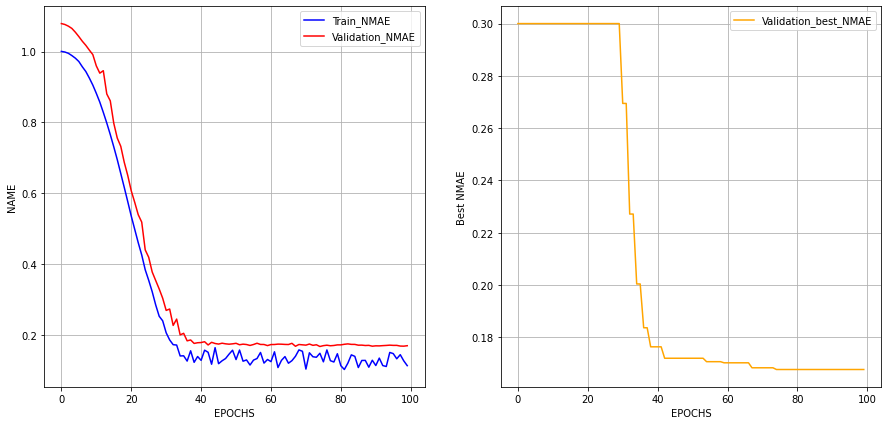

In [ ]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_nmae_list)), train_nmae_list, color='blue', label='Train_NMAE')
plt.plot(range(len(train_nmae_list)), vali_nmae_list, color='red', label='Validation_NMAE')
plt.grid()
plt.xlabel('EPOCHS')
plt.ylabel('NAME')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(len(train_nmae_list)), vali_best_nmae_list, color='orange', label='Validation_best_NMAE')
plt.grid()
plt.xlabel('EPOCHS')
plt.ylabel('Best NMAE')
plt.legend()

plt.show()

## Inference

In [ ]:
def predict(model, test_loader, device):
    model.eval()
    model_pred = []
    with torch.no_grad():
        for img, meta in tqdm(iter(test_loader)):
            img, meta = img.float().to(device), meta.float().to(device)

            pred_logit = model(img, meta)
            pred_logit = pred_logit.squeeze(1).detach().cpu()

            for idx, i in enumerate(pred_logit):
              if i < 0:
                pred_logit[idx] = 0

            model_pred.extend(pred_logit.tolist())
    return model_pred

In [ ]:
test_dataset = CustomDataset(test_img_, test_meta_, None, train_mode=False, transforms=test_transform)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)


checkpoint = torch.load('./best_nmae/'+name+'_best_model.pth')
model = cnn.to(device)
model.load_state_dict(checkpoint)

# Inference
preds = predict(model, test_loader, device)

  0%|          | 0/4 [00:00<?, ?it/s]

## Submission

In [ ]:
submission = pd.read_csv('./sample_submission.csv')
submission['leaf_weight'] = preds
submission.to_csv('./submit.csv', index=False)